In [1]:
library(qiime2R)
library("phyloseq")
library("ggplot2")
library("ape")
library("vegan")
library(tidyr)
library(dplyr)
library(tibble)
library("pairwiseAdonis"); packageVersion("pairwiseAdonis")
library(limma)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: cluster



[1] ‘0.0.1’

In [2]:

ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/sedimentXaymara/2022_analysis/table_Micro_sed_2022.qza")
ASV_table <- ASV_qza$data
head(ASV_table)


taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/sedimentXaymara/2022_analysis/taxonomy_sed_2022.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

tree_file <-read_qza("/Users/stephanie.rosales/Documents/sedimentXaymara/2022_analysis/root_masked_aligned_rep_sed_2022.qza")$data


map<- read.table("/Users/stephanie.rosales/Documents/sedimentXaymara/Meta_sediment_larvae.txt", 
                 row.names = 1, 
                 header = TRUE)

,E1,E2,E3,E4,P1-2016,P1-2017,P2-2016,P2-2017,P3-2016,P3-2017,P4-2016,R1B,R1C,R2B,R2C
0136830f03fcec54d4ca4bdbf2eab937,0,0,0,0,18,0,12,0,13,0,6,0,0,0,0
a4cb74ec52c0e380c3ba6c90f9761851,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
30941f92e3ff90c6bddb92bea339fb09,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0
aa41c0727d338e49952fd767770d7cdc,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0
faa78debe27eda3d51b6f523e16cc26a,0,0,0,0,6,0,0,0,6,0,0,0,0,0,0
16b3ecdef9b1d9e74b5a29095793bc44,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 789 rows [2713, 2822, 3224, 4158, 4223, 4242, 4871, 5283, 5628, 5753, 5758, 5768, 5876, 5921, 5962, 6049, 6297, 6396, 6460, 6689, ...].”


In [3]:
ps = phyloseq(otu_table(t(ASV_table), taxa_are_rows=FALSE), 
               sample_data(map),
tax_table(taxa_table), tree_file)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 29141 taxa and 15 samples ]
sample_data() Sample Data:       [ 15 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 29141 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 29141 tips and 29101 internal nodes ]

In [4]:
map = map %>% mutate()

In [5]:
ps_2017 = subset_samples(ps,  Year=="Y2017")
                                              
ps_2017

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 29141 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 29141 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 29141 tips and 29101 internal nodes ]

In [6]:
ps_2017_fil1  = filter_taxa(ps_2017 , function(x) sum(x > 10) > (0.30*length(x)), TRUE)
ps_2017_fil1

ps_fill  = filter_taxa(ps , function(x) sum(x > 10) > (0.30*length(x)), TRUE)
ps_fill

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1852 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 1852 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1852 tips and 1843 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2469 taxa and 15 samples ]
sample_data() Sample Data:       [ 15 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 2469 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2469 tips and 2458 internal nodes ]

In [7]:
ps_fill  = filter_taxa(ps , function(x) sum(x > 10) > (0.30*length(x)), TRUE)
ps_fill

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2469 taxa and 15 samples ]
sample_data() Sample Data:       [ 15 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 2469 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2469 tips and 2458 internal nodes ]

In [8]:
#CLR transformation
ps_clr <- microbiome::transform(ps_2017_fil1, 'clr')

In [9]:
ps_ra <- microbiome::transform(ps_2017_fil1, 'compositional') %>%
tax_glom("Order")
sum_ps =  psmelt(ps_ra) 
dim(sum_ps)

[1] 1169   22

In [10]:
ps_ra_all = transform_sample_counts(ps_fill, function(x) x / sum(x)) %>%
tax_glom("Family")%>% psmelt()

In [11]:
library(RColorBrewer)
nb.cols <- 18
mycolors <- colorRampPalette(brewer.pal(8, "Set1"))(nb.cols)

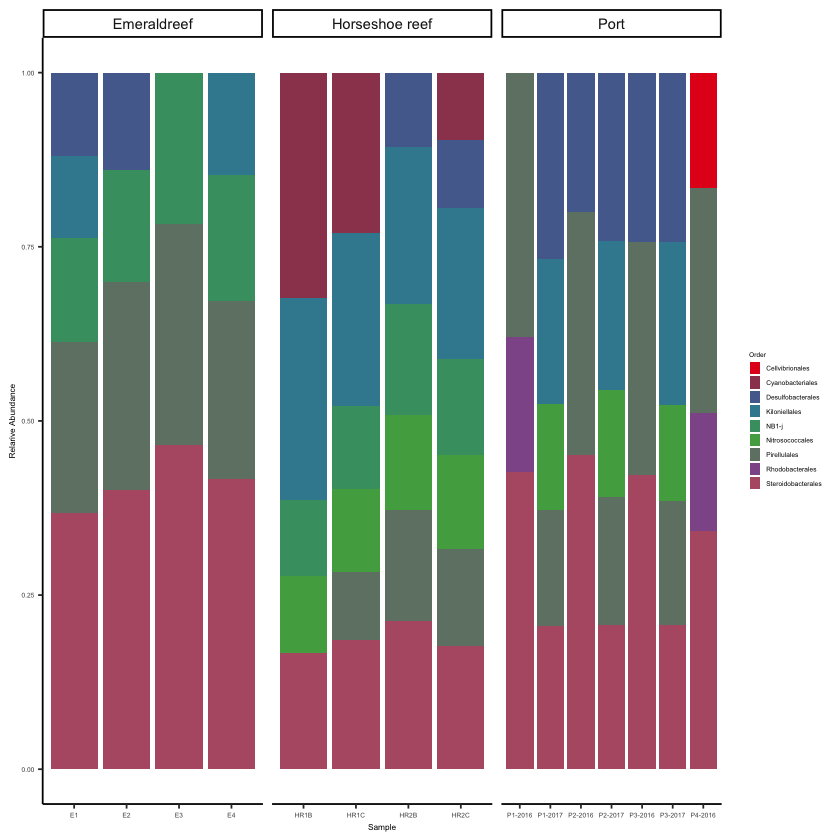

In [12]:
RA_sup = ps_ra_all %>%
subset(Abundance >0.04) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Horseshoereef",
                replacement = "Horseshoe reef")  %>%
ggplot(  
       aes(x = ID, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
scale_fill_manual(values = mycolors) +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.60, ncol=1)) +
theme_classic() +
facet_grid(.~Site, scales="free") +
theme(legend.text =element_text(size=4)) +
theme(legend.title =element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_text(size =4)) +
ylab("Relarive Abundance") +
xlab("Sample")

RA_sup

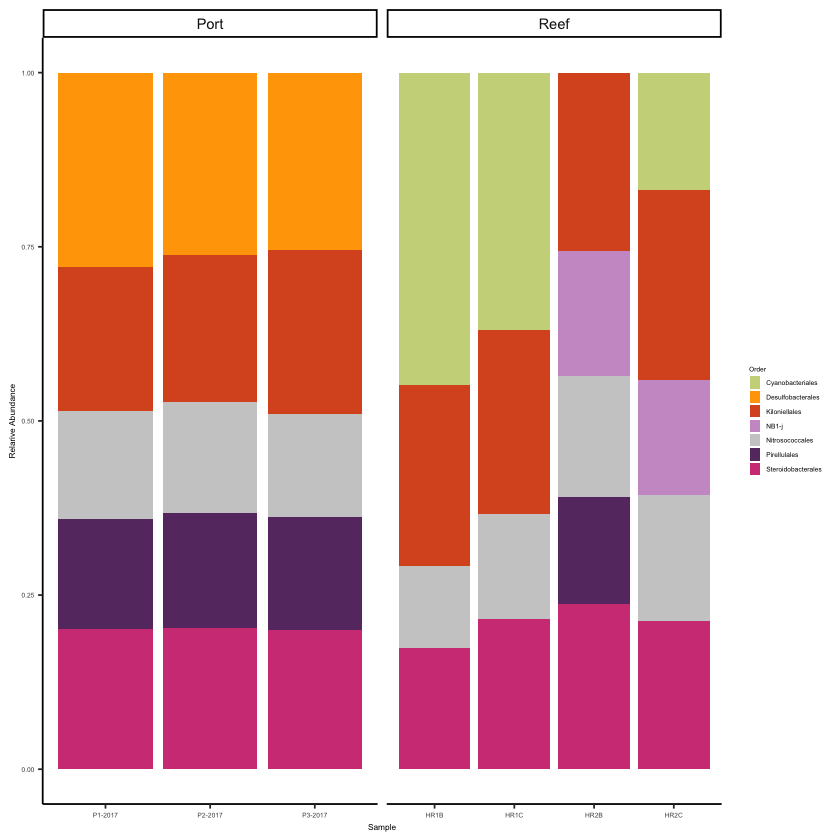

In [13]:
RA = sum_ps %>%
subset(Abundance >0.05) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Horseshoereef",
                replacement = "Reef")  %>%
ggplot(  
       aes(x = ID, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
scale_fill_manual(values=c("#CBD588", "orange","#DA5724",
                  "#CD9BCD", "gray80", "#673770","#D14285",
                  "#652926")) +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.60, ncol=1)) +
theme_classic() +
facet_grid(.~Site, scales="free") +
theme(legend.text =element_text(size=4)) +
theme(legend.title =element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_text(size =4)) +
ylab("Relarive Abundance") +
xlab("Sample")

RA

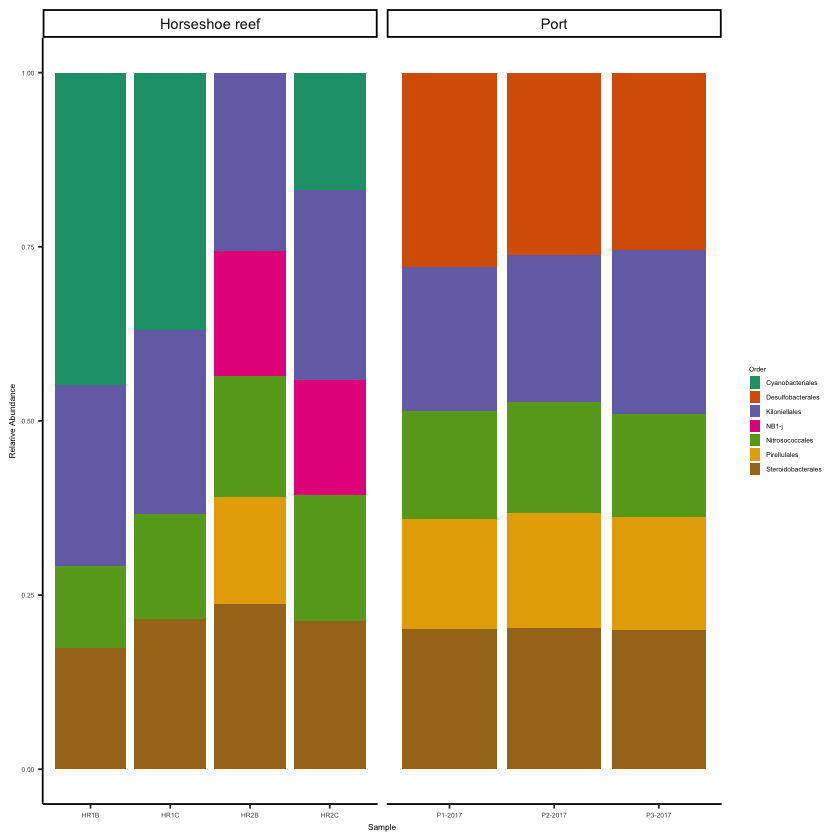

In [14]:
RA = sum_ps %>%
subset(Abundance >0.05) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Horseshoereef",
                replacement = "Horseshoe reef")  %>%
ggplot(  
       aes(x = ID, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
scale_fill_brewer(palette = "Dark2") +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.60, ncol=1)) +
theme_classic() +
facet_grid(.~Site, scales="free") +
theme(legend.text =element_text(size=4)) +
theme(legend.title =element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_text(size =4)) +
ylab("Relarive Abundance") +
xlab("Sample")

RA

In [15]:
dis <- vegdist(otu_table(ps_clr), method ="euclidean")
#homogeneity of group dispersions (variances).
mod <- betadisper(dis, sample_data(ps_clr)$Site)
mod
## Permutation test for F
permutest(mod)




	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = sample_data(ps_clr)$Site)

No. of Positive Eigenvalues: 6
No. of Negative Eigenvalues: 0

Average distance to median:
Horseshoereef          Port 
        55.76         41.99 

Eigenvalues for PCoA axes:
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 
22615  6399  3616  2722  2432  2117 

Set of permutations < 'minperm'. Generating entire set.




Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 5039

Response: Distances
          Df Sum Sq Mean Sq    F N.Perm Pr(>F)  
Groups     1 324.98  324.98 4.63    999  0.032 *
Residuals  5 350.95   70.19                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [16]:

#convert meta data to dataframe
df_clr= as(sample_data(ps_clr), "data.frame")
#All samples
adonis(otu_table(ps_clr)~ Site, 
       data =df_clr, permutations = 999, 
         method = "euclidean")


Set of permutations < 'minperm'. Generating entire set.




Call:
adonis(formula = otu_table(ps_clr) ~ Site, data = df_clr, permutations = 999,      method = "euclidean") 

Permutation: free
Number of permutations: 5039

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Site       1     21971 21970.9   6.127 0.55064  0.038 *
Residuals  5     17929  3585.9         0.44936         
Total      6     39900                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [17]:

ps.ord_clr <- ordinate(ps_clr, "RDA", "euclidean")

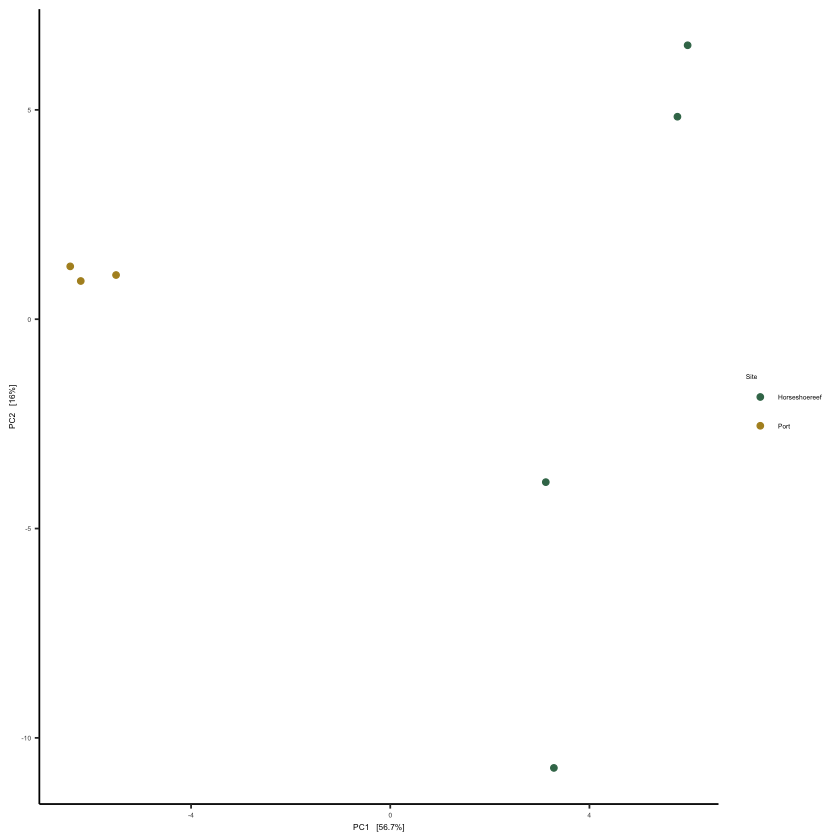

In [18]:
beta = plot_ordination(ps_clr, ps.ord_clr,
                            
                                  color="Site"
               ) +
scale_color_manual(values=c("#3c7658",
  "#b08f26")) +
theme_classic() +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
labs(color='Site') 
# theme(legend.position = "none",
 #     panel.grid.minor.x = element_blank())

beta

In [19]:
library(ANCOMBC)

In [20]:
ps_2017_fill2  = filter_taxa(ps_2017 , function(x) sum(x > 12) > (0.40*length(x)), TRUE)
ps_2017_fill2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1724 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 1724 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1724 tips and 1715 internal nodes ]

In [21]:
out = ancombc(phyloseq = ps_2017 , formula = "Site", 
              p_adj_method = "fdr", zero_cut = 0.95, lib_cut = 1000, 
              group = "Site", struc_zero = TRUE, neg_lb = TRUE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.001, global = FALSE)

res = out$res
res_global = out$res_global

Warning message in data_prep(phyloseq, group, zero_cut, lib_cut, global = global):
“The multi-group comparison will be deactivated as the group variable has < 3 categories.”


In [22]:
res_beta = data.frame(res$beta * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("taxon_id")

head(res_beta)

dim(res_beta)

res_se = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("taxon_id")
colnames(res_se)[-1] = paste0(colnames(res_se)[-1], "SD")
head(res_se)


df_fig = res_beta %>% left_join(res_se, by = "taxon_id") %>%
  transmute(taxon_id, SitePort, SitePortSD)%>%
  mutate(group = ifelse(SitePort > 0, "Port", "Horseshoereef"))
df_fig$taxon_id = factor(df_fig$taxon_id, levels = df_fig$taxon_id)


sigs=res$diff_abn %>% as.data.frame() %>%
select(SitePort)  %>%
filter(SitePort=="TRUE") %>%
rownames_to_column("taxon_id") %>%
rename(Sig=SitePort)
dim(sigs)
head(sigs)



df_fig =df_fig %>% inner_join(sigs)

dim(df_fig)



,taxon_id,SitePort
,<chr>,<dbl>
1,a58375aff6b5485b77c932bd78ada7e9,0
2,b381153c571ed66e1bc7abc913dee4f5,0
3,d72e819ea346cdb64f2670535e07f228,0
4,89e870c8da53386856d18eb1ef115538,0
5,fc48edbcb1824a0bad546c977c655089,0
6,433dd4301c1037e9cbc71042c3c9f376,0


[1] 14872     2

,taxon_id,SitePortSD
,<chr>,<dbl>
1,a58375aff6b5485b77c932bd78ada7e9,0
2,b381153c571ed66e1bc7abc913dee4f5,0
3,d72e819ea346cdb64f2670535e07f228,0
4,89e870c8da53386856d18eb1ef115538,0
5,fc48edbcb1824a0bad546c977c655089,0
6,433dd4301c1037e9cbc71042c3c9f376,0


[1] 3326    2

,taxon_id,Sig
,<chr>,<lgl>
1,107a9991eaf4f3aa51793f3cb2ff22a6,TRUE
2,dcd0d4dcffb8909bcb4e761ad9007c54,TRUE
3,8becec2b862fb6c844af166c11f44e99,TRUE
4,41f0bdf67f70e23a549ccaecb5f3aeaa,TRUE
5,f13881400a19832b5c51cdda8c5c5bc9,TRUE
6,71aa61403905e2ad77614f4b70d84b39,TRUE


Joining, by = "taxon_id"


[1] 3326    5

In [23]:
head(df_fig)
head(taxa_table)

,taxon_id,SitePort,SitePortSD,group,Sig
,<chr>,<dbl>,<dbl>,<chr>,<lgl>
1,107a9991eaf4f3aa51793f3cb2ff22a6,1.5045770,0.4400159,Port,TRUE
2,dcd0d4dcffb8909bcb4e761ad9007c54,-0.6458786,0.5859031,Horseshoereef,TRUE
3,8becec2b862fb6c844af166c11f44e99,-1.2485282,0.8843989,Horseshoereef,TRUE
4,41f0bdf67f70e23a549ccaecb5f3aeaa,-1.3300785,0.8991288,Horseshoereef,TRUE
5,f13881400a19832b5c51cdda8c5c5bc9,-2.1938414,0.7451972,Horseshoereef,TRUE
6,71aa61403905e2ad77614f4b70d84b39,-2.9856787,0.7341597,Horseshoereef,TRUE


,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs
0004a2f7e6b5219b590f0ffb8ddd103f,Unassigned,NA,NA,NA,NA,NA,NA,1,ASV_1
000681633c3f5ff52cd46f4a26389a13,d__Bacteria,p__Bdellovibrionota,c__Oligoflexia,o__Oligoflexales,f__uncultured,g__uncultured,s__metagenome,1,ASV_2
00068c1298a373c2184be99e7653b8fb,d__Bacteria,p__Verrucomicrobiota,c__Kiritimatiellae,o__WCHB1-41,f__WCHB1-41,g__WCHB1-41,s__uncultured_bacterium,1,ASV_3
00069c9d2e2e6e329c0f31429f1aceda,d__Bacteria,p__Cyanobacteria,c__Cyanobacteriia,o__Chloroplast,f__Chloroplast,g__Chloroplast,s__uncultured_bacterium,1,ASV_4
000ebdca566b3010ffeeed03dc040c66,d__Bacteria,p__Acidobacteriota,c__Subgroup_22,o__Subgroup_22,f__Subgroup_22,g__Subgroup_22,s__uncultured_Acidobacteria,1,ASV_5
00152cc6d616532ab05ef9e93d2b4087,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Woesearchaeales,f__Woesearchaeales,g__Woesearchaeales,s__uncultured_euryarchaeote,1,ASV_6


In [24]:
as.data.frame(taxa_table) %>%
rownames_to_column("taxon_id") %>%
head

,taxon_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0004a2f7e6b5219b590f0ffb8ddd103f,Unassigned,NA,NA,NA,NA,NA,NA,1,ASV_1
2,000681633c3f5ff52cd46f4a26389a13,d__Bacteria,p__Bdellovibrionota,c__Oligoflexia,o__Oligoflexales,f__uncultured,g__uncultured,s__metagenome,1,ASV_2
3,00068c1298a373c2184be99e7653b8fb,d__Bacteria,p__Verrucomicrobiota,c__Kiritimatiellae,o__WCHB1-41,f__WCHB1-41,g__WCHB1-41,s__uncultured_bacterium,1,ASV_3
4,00069c9d2e2e6e329c0f31429f1aceda,d__Bacteria,p__Cyanobacteria,c__Cyanobacteriia,o__Chloroplast,f__Chloroplast,g__Chloroplast,s__uncultured_bacterium,1,ASV_4
5,000ebdca566b3010ffeeed03dc040c66,d__Bacteria,p__Acidobacteriota,c__Subgroup_22,o__Subgroup_22,f__Subgroup_22,g__Subgroup_22,s__uncultured_Acidobacteria,1,ASV_5
6,00152cc6d616532ab05ef9e93d2b4087,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Woesearchaeales,f__Woesearchaeales,g__Woesearchaeales,s__uncultured_euryarchaeote,1,ASV_6


In [25]:

res_ancom = as.data.frame(taxa_table) %>%
rownames_to_column("taxon_id") %>%
right_join(df_fig, "taxon_id") %>%
column_to_rownames("taxon_id")%>%
filter(SitePort > 3.5 | SitePort < -3.5)

head(res_ancom)
dim(res_ancom)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs,SitePort,SitePortSD,group,Sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>
003bc48308e12eff589fe5d83b984df2,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__alpha_proteobacterium,1,ASV_23,-4.549762,0.34341100,Horseshoereef,TRUE
02e98921249e4b954f00920f3a2b12a0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Gammaproteobacteria_Incertae_Sedis,f__Unknown_Family,g__uncultured,s__uncultured_Chromatiales,1,ASV_343,3.911856,0.17102514,Port,TRUE
038a13a35cbc6dbfb5003517507ed22b,d__Bacteria,p__Actinobacteriota,c__Acidimicrobiia,o__Actinomarinales,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_425,3.644808,0.17981666,Port,TRUE
0395789502ff2dfe51e1531b793abe6e,d__Bacteria,p__Planctomycetota,c__Planctomycetes,o__Pirellulales,f__Pirellulaceae,g__Rhodopirellula,s__uncultured_organism,1,ASV_430,4.162590,0.97809625,Port,TRUE
03a2c812cb0cf15ce21268a1f0a2ad07,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Tenderiales,f__Tenderiaceae,g__Candidatus_Tenderia,s__uncultured_gamma,1,ASV_438,4.413192,0.14311548,Port,TRUE
050dbaf1c8d169ef75b6fdbc7fc19632,d__Bacteria,p__Planctomycetota,c__Planctomycetes,o__Pirellulales,f__Pirellulaceae,g__Blastopirellula,s__uncultured_planctomycete,1,ASV_623,4.266607,0.09696464,Port,TRUE


[1] 293  13

In [26]:


res_ancom %>%
count(Order,, sort = TRUE) %>% tally()

res_ancom %>%
count(Family,, sort = TRUE) %>% tally()

res_ancom %>%
count(Genus, sort = TRUE) %>% tally()

res_ancom %>%
count(Order,, sort = TRUE) 

n
<int>
74


n
<int>
82


n
<int>
96


Order,n
<chr>,<int>
o__Steroidobacterales,29
o__Desulfobacterales,19
o__Pirellulales,15
o__Nitrosococcales,12
o__Desulfobulbales,10
o__Kiloniellales,10
o__uncultured,10
o__Thermoanaerobaculales,9
o__Cellvibrionales,8


In [37]:
res_ancom %>%
filter(SitePort > 3.5) %>% 
count(ASVs,, sort = TRUE) %>% 
tally()

res_ancom %>%
filter(SitePort < - 3.5) %>% 
count(ASVs,, sort = TRUE) %>% 
tally()

n
<int>
223


n
<int>
70


In [27]:
res_ancom %>%
arrange(-SitePort) %>%
head(n=20)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs,SitePort,SitePortSD,group,Sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>
a519de96928407f681ce7aba7ce257ef,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Ectothiorhodospirales,f__Ectothiorhodospiraceae,g__Thiogranum,s__uncultured_bacterium,1,ASV_19837,6.338484,0.10673803,Port,TRUE
de178205603ffdee0d073b5d0df944b7,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_26775,6.249658,0.10088704,Port,TRUE
d181f8e110a6261bef573c10a6c748cb,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Thiotrichales,f__Thiotrichaceae,g__uncultured,s__uncultured_gamma,1,ASV_25200,6.126785,0.55057889,Port,TRUE
cb86bc654c5c98fa287cca1418349b81,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Ectothiorhodospirales,f__Thioalkalispiraceae,g__Thiohalophilus,s__uncultured_gamma,1,ASV_24497,5.537599,0.09813092,Port,TRUE
5b25fd394d41c4246602e4919f7791cd,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Ectothiorhodospirales,f__Thioalkalispiraceae,g__Thiohalophilus,s__uncultured_gamma,1,ASV_10955,5.434719,0.07116482,Port,TRUE
65beaa1bcbb774a941b314d5968b716e,d__Bacteria,p__Desulfobacterota,c__Desulfobacteria,o__Desulfobacterales,f__Desulfosarcinaceae,g__Sva0081_sediment_group,s__uncultured_delta,1,ASV_12261,5.413032,0.08274786,Port,TRUE
9deb8b62e438914c575ead757a90158e,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_18969,5.399164,0.07658054,Port,TRUE
22040c5ed637a41c62d703e858983680,d__Bacteria,p__Desulfobacterota,c__Desulfobacteria,o__Desulfobacterales,f__Desulfosarcinaceae,g__Sva0081_sediment_group,s__uncultured_bacterium,1,ASV_4014,5.382486,0.12659280,Port,TRUE
e5d6c6f9ddf4bde01465aeb559d9d631,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_27708,5.382171,0.15670277,Port,TRUE


In [28]:
res_ancom %>%
arrange(SitePort) %>%
head(n=20)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs,SitePort,SitePortSD,group,Sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>
8566d8f03a40708261621f9a32a08290,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Moritellaceae,g__uncultured,s__uncultured_gamma,1,ASV_16094,-4.826259,0.13136190,Horseshoereef,TRUE
8f7ffdda2f7dc68266281199f201d584,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_17268,-4.765103,0.10990259,Horseshoereef,TRUE
32ca1b2d098f80cef755f7f7b082be6e,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_6013,-4.731514,0.11824813,Horseshoereef,TRUE
192ced660ee795fef90b4610b45b6efc,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Nitrosococcales,f__Nitrosococcaceae,g__AqS1,s__uncultured_bacterium,1,ASV_3026,-4.729246,0.25956093,Horseshoereef,TRUE
0cd8bfc05e925cdbc63b8e0e1a1551c0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_1558,-4.657329,0.10708724,Horseshoereef,TRUE
f2aa7b2ec051c6d48d6e2541e06666dd,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_29344,-4.563561,0.24483769,Horseshoereef,TRUE
68c3fb2633a363d46325e61df1dbe172,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__BD7-8,f__BD7-8,g__BD7-8,s__uncultured_bacterium,1,ASV_12619,-4.562700,0.15570359,Horseshoereef,TRUE
003bc48308e12eff589fe5d83b984df2,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__alpha_proteobacterium,1,ASV_23,-4.549762,0.34341100,Horseshoereef,TRUE
3b41e508e555f8e891fb86139142cc87,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Moritellaceae,g__uncultured,s__uncultured_gamma,1,ASV_7048,-4.546825,0.39426321,Horseshoereef,TRUE


In [29]:
res_ancom %>%
filter(SitePort<0)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,Consensus,ASVs,SitePort,SitePortSD,group,Sig
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>
003bc48308e12eff589fe5d83b984df2,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__alpha_proteobacterium,1,ASV_23,-4.549762,0.34341100,Horseshoereef,TRUE
0cd8bfc05e925cdbc63b8e0e1a1551c0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_1558,-4.657329,0.10708724,Horseshoereef,TRUE
0fe316b34b32472c9ab72dfb8b0105cd,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__uncultured,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_1916,-3.921154,0.16657440,Horseshoereef,TRUE
128ef214d72c6ad3265787b08e73be32,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Steroidobacterales,f__Woeseiaceae,g__Woeseia,s__uncultured_bacterium,1,ASV_2249,-3.963772,0.22647551,Horseshoereef,TRUE
165b679547433df53038f2e536a3086c,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Cellvibrionales,f__Halieaceae,g__Pseudohaliea,s__Haliea_sp.,1,ASV_2684,-3.792313,0.25838385,Horseshoereef,TRUE
1684d1f41338104dbc1f2238f16b06a2,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Thalassobaculales,f__uncultured,g__uncultured,s__mucus_bacterium,1,ASV_2701,-3.573280,0.46879092,Horseshoereef,TRUE
192ced660ee795fef90b4610b45b6efc,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Nitrosococcales,f__Nitrosococcaceae,g__AqS1,s__uncultured_bacterium,1,ASV_3026,-4.729246,0.25956093,Horseshoereef,TRUE
1b8ebc717c930b1cd6692c400e371619,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Defluviicoccales,f__uncultured,g__uncultured,s__uncultured_bacterium,1,ASV_3274,-4.029645,0.16488102,Horseshoereef,TRUE
2049bef7aef2325c46bab0092812277b,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Nitrosococcales,f__Nitrosococcaceae,g__FS142-36B-02,s__uncultured_gamma,1,ASV_3803,-3.741716,0.18610839,Horseshoereef,TRUE


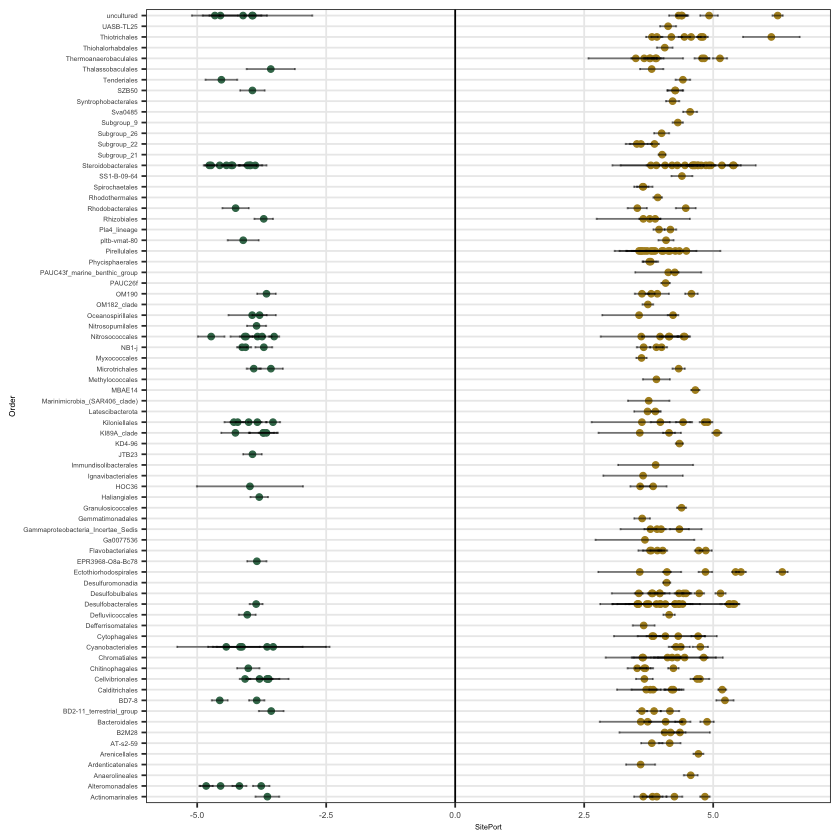

In [38]:
ancom_fig = res_ancom %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "g__",
                replacement = "")  %>%
ggplot( 
           aes(SitePort, y = Order)
              ) + 
geom_point(aes(color=group)) +
   #geom_bar(stat = "identity", width = 1) +
           #, position = position_(width = 0.3)) +
  theme_bw() + 
 theme(legend.position = "none",
       panel.grid.minor.x = element_blank()) +
  
geom_errorbar(aes(xmin = SitePort - SitePortSD, xmax = SitePort + SitePortSD),
                width = 0.2,
                position = position_dodge(0.03), color = "black", alpha=0.5) + 
#scale_fill_manual(values=c("#40B5AD", "#6F8FAF")) +
 labs(y = "Order", x = "Reef vs Port (Log fold change)") + 
#theme(strip.background = element_rect(fill="white")) +
scale_color_manual(values=c("#3c7658",
  "#b08f26"
)) +
theme(axis.title.x = element_text(size = 4.5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.y = element_text(size=4)) +
theme(axis.text.x = element_text(size =5)) +
#theme(strip.text.y = element_blank()) +
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
#theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=5)) +
#facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
#theme(strip.text.y = element_text(size = 5)) +
geom_vline(xintercept = 0,  
                color = "black", size=.5)

ancom_fig
ggsave("/Users/stephanie.rosales/Documents/sedimentXaymara/2022_analysis/figures/sed_ANCOM.png",
     width = 4, height = 4, units = "in", dpi=300)

In [31]:
ps_2017_fill3  = filter_taxa(ps_2017 , function(x) sum(x > 0) > (0.00*length(x)), TRUE)
ps_2017_fill3


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 14872 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 14872 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 14872 tips and 14851 internal nodes ]

In [32]:
ps_rare <- phyloseq::rarefy_even_depth(ps_2017_fill3, rngseed = 123, replace = TRUE, sample.size=60000)


`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

897OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [33]:
?phyloseq::estimate_richnessInvSimpson

In [52]:
div <- data.frame(
  "Observed" = phyloseq::estimate_richness(ps_rare, measures = "Observed"),
  "Shannon" = phyloseq::estimate_richness(ps_rare, measures = "Shannon"),
  "InvSimpson" = phyloseq::estimate_richness(ps_rare, measures = "InvSimpson"),
  "Site" = phyloseq::sample_data(ps_rare)$Site)

div

,Observed,Shannon,InvSimpson,Site
,<dbl>,<dbl>,<dbl>,<chr>
P1.2017,3001,7.198109,584.8082,Port
P2.2017,2482,7.031049,519.3485,Port
P3.2017,3883,7.413877,671.9810,Port
R1B,3792,7.206144,360.8405,Horseshoereef
R1C,3416,7.278561,527.5990,Horseshoereef
R2B,2704,7.243930,780.8758,Horseshoereef
R2C,4144,7.570800,914.4585,Horseshoereef


In [53]:
div_new =as.data.frame(div) %>%
  gather(key = metric, value = value, c("Observed", "Shannon", "InvSimpson")) %>%
  mutate(metric = factor(metric, levels = c("Observed", "Shannon", "InvSimpson")))

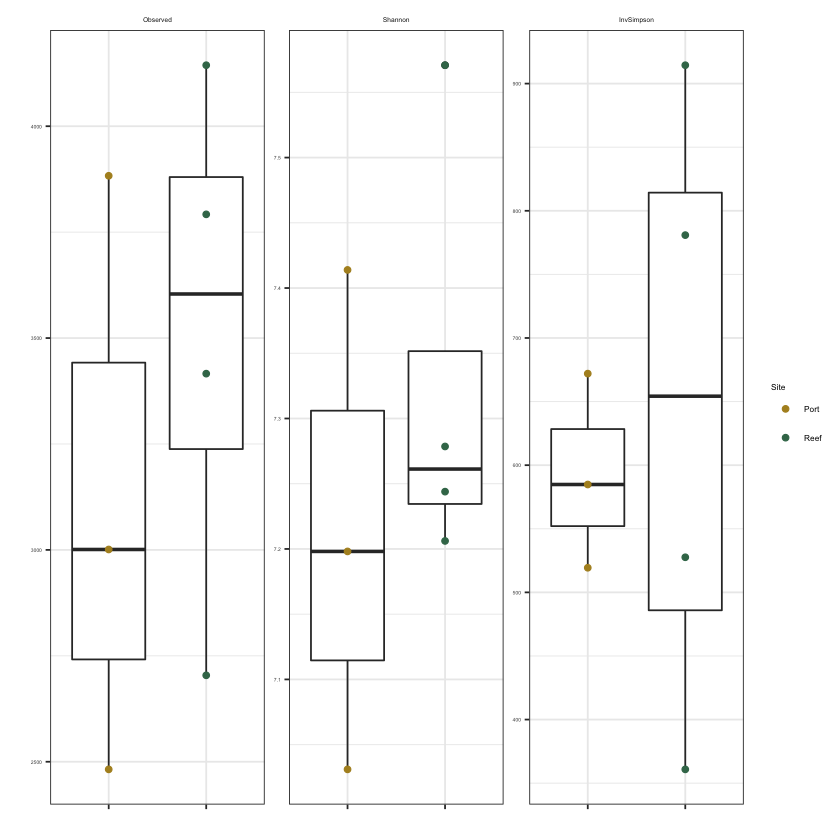

In [55]:
alpha = div_new %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Horseshoereef",
                replacement = "Reef")  %>%
ggplot(aes(x = Site, y = value)) +
  geom_boxplot() +
  geom_point(aes(color = Site)) +
theme_bw() +

scale_color_manual(values=c("#b08f26",
"#3c7658"
)) +
  labs(x = "", y = "")  +
  facet_wrap(.~ metric, scales = "free") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.text.x = element_blank()) +
theme(axis.text.y = element_text(size =3)) +
theme(strip.background = element_blank()) +
theme(strip.text.x = element_text(size = 4)) 
alpha

In [37]:
library(lme4)
library(lsmeans)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: emmeans

The 'lsmeans' package is now basically a front end for 'emmeans'.
Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.



In [38]:
head(div)

,Observed,Shannon,InvSimpson,Site
,<dbl>,<dbl>,<dbl>,<chr>
P1.2017,3001,7.198109,584.8082,Port
P2.2017,2482,7.031049,519.3485,Port
P3.2017,3883,7.413877,671.9810,Port
R1B,3792,7.206144,360.8405,Horseshoereef
R1C,3416,7.278561,527.5990,Horseshoereef
R2B,2704,7.243930,780.8758,Horseshoereef


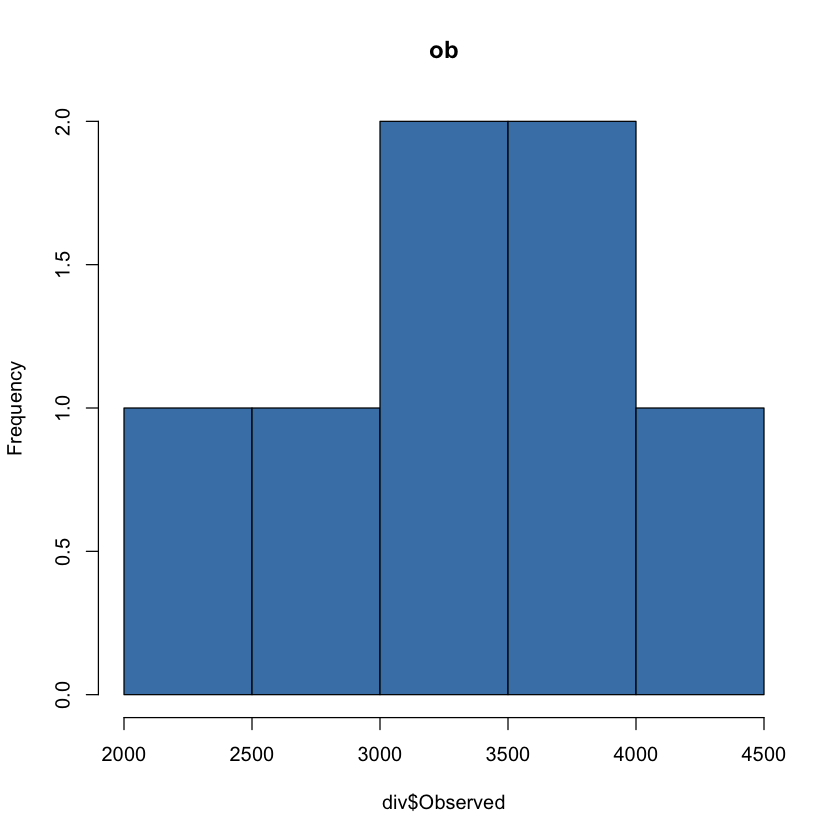


	Shapiro-Wilk normality test

data:  div$Observed
W = 0.94051, p-value = 0.6433


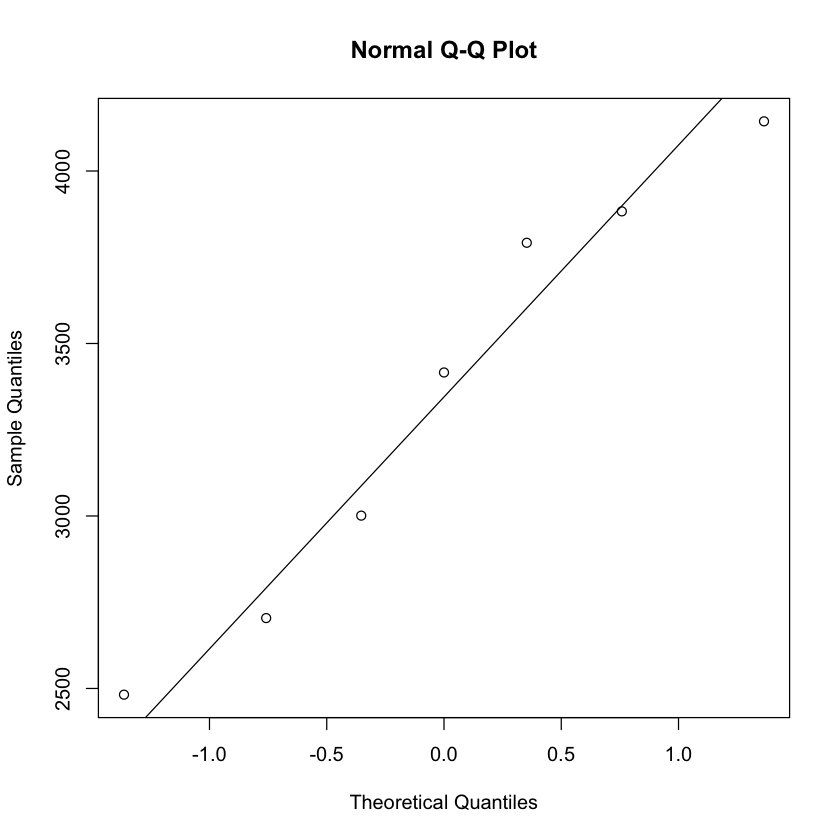

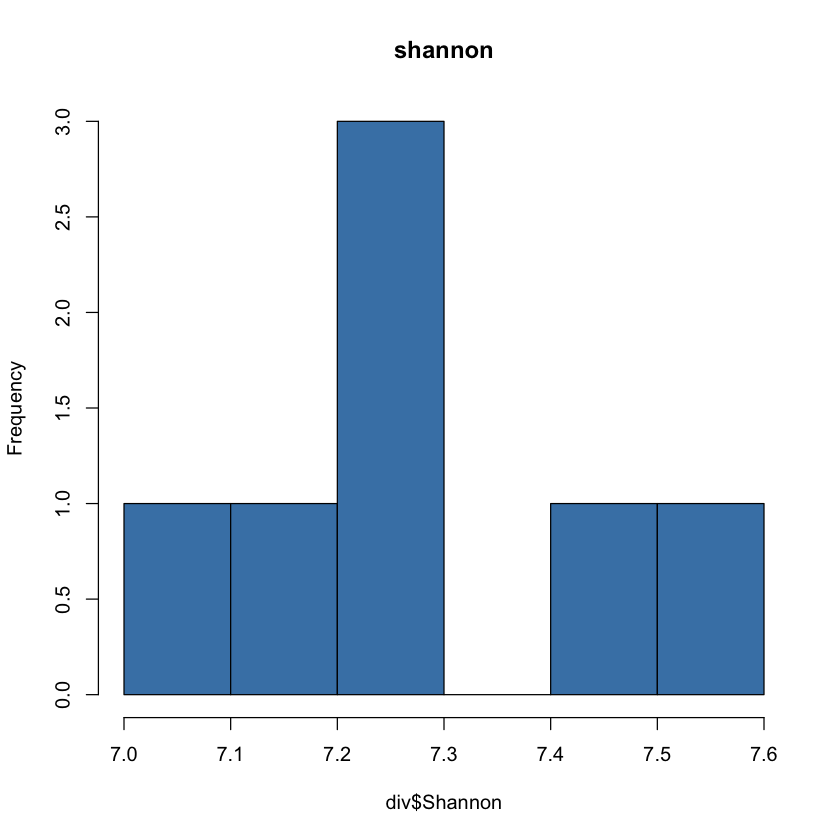


	Shapiro-Wilk normality test

data:  div$Shannon
W = 0.95389, p-value = 0.7649


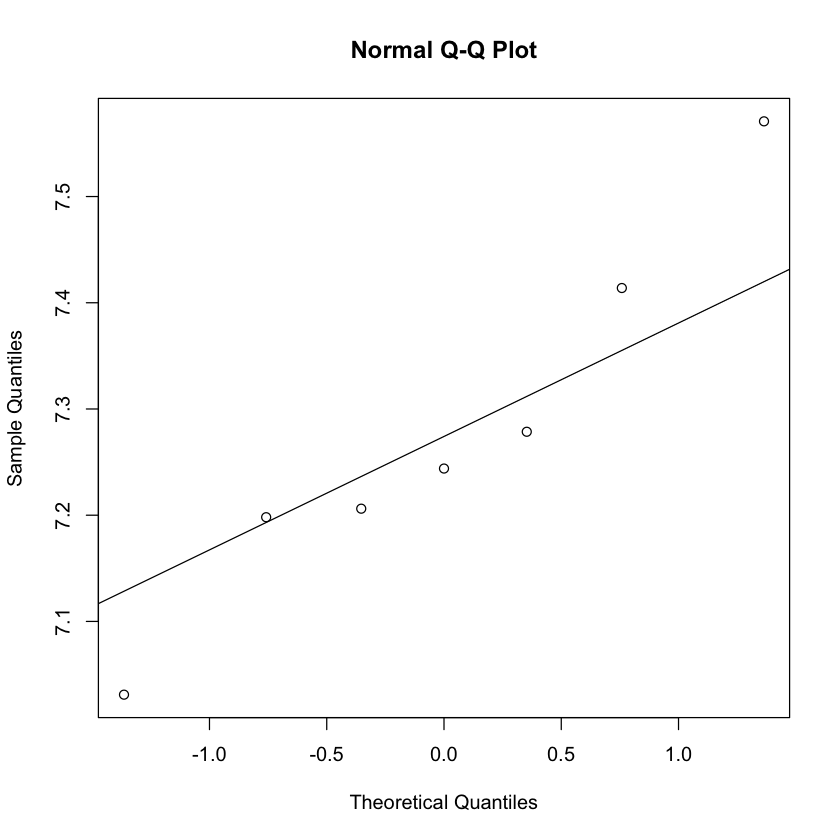

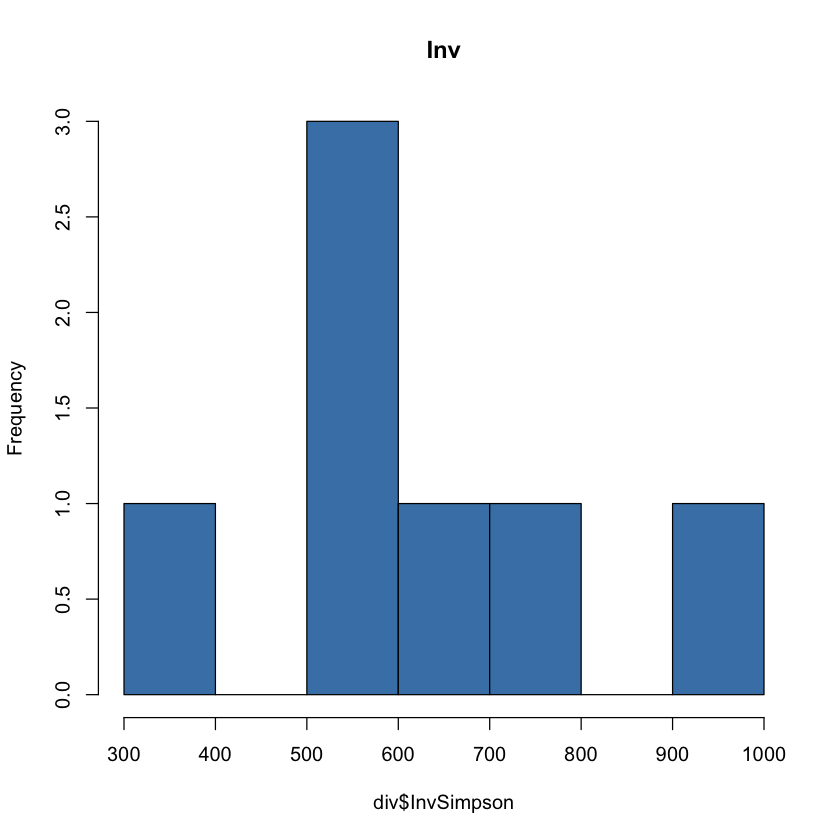


	Shapiro-Wilk normality test

data:  div$InvSimpson
W = 0.97704, p-value = 0.944


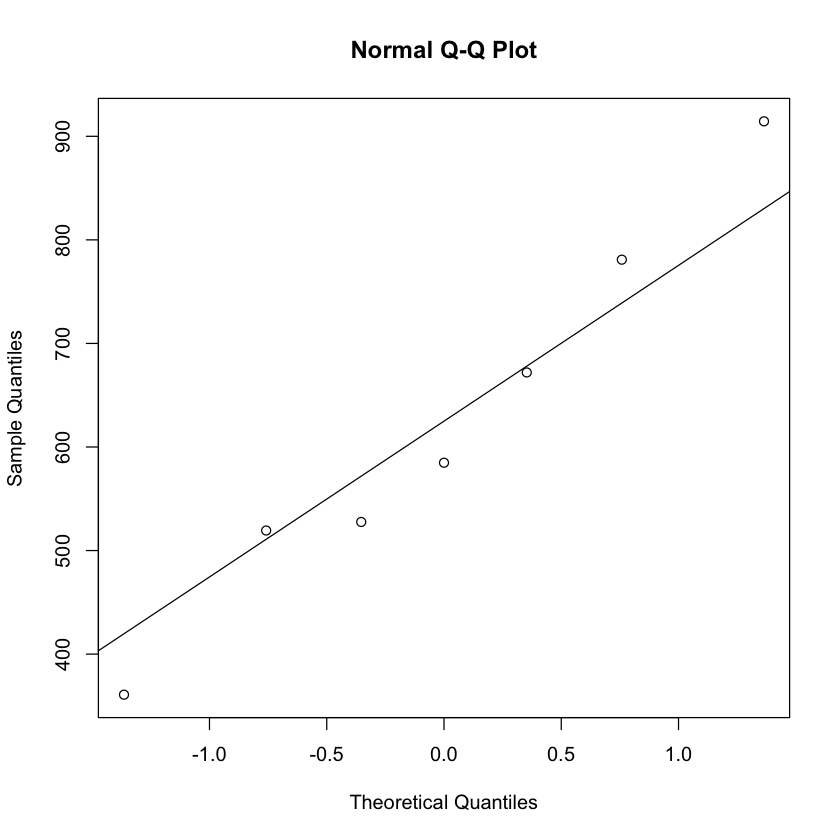

In [39]:
hist(div$Observed, col='steelblue', main='ob')
qqnorm(div$Observed)
qqline(div$Observed)
shapiro.test(div$Observed)
hist(div$Shannon, col='steelblue', main='shannon')
qqnorm(div$Shannon)
qqline(div$Shannon)
shapiro.test(div$Shannon)
hist(div$InvSimpson, col='steelblue', main='Inv')
qqnorm(div$InvSimpson)
qqline(div$InvSimpson)
shapiro.test(div$InvSimpson)

In [40]:
div %>%
  group_by(Site) %>%
  dplyr::summarise(median_observed = median(Observed),
            median_shannon = median(Shannon),
                 median_InvSimpson = median(InvSimpson))

Site,median_observed,median_shannon,median_InvSimpson
<chr>,<dbl>,<dbl>,<dbl>
Horseshoereef,3604,7.261246,654.2374
Port,3001,7.198109,584.8082


In [41]:
anova_ob= aov(Observed ~Site, div)
summary(aov(Observed ~Site, div))
#TukeyHSD(anova_ob)
summary(aov(Shannon ~Site, div))
summary(aov(InvSimpson ~Site, div))


            Df  Sum Sq Mean Sq F value Pr(>F)
Site         1  263424  263424   0.615  0.469
Residuals    5 2143250  428650               

            Df  Sum Sq Mean Sq F value Pr(>F)
Site         1 0.02094 0.02094   0.667  0.451
Residuals    5 0.15695 0.03139               

            Df Sum Sq Mean Sq F value Pr(>F)
Site         1   4980    4980   0.126  0.737
Residuals    5 197323   39465               

In [42]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate




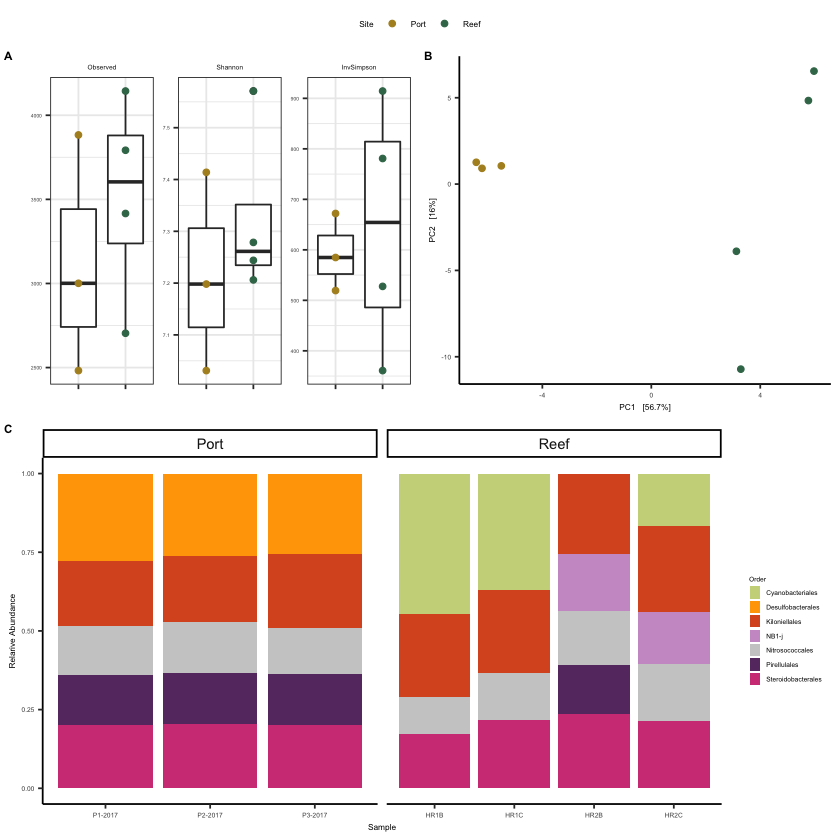

In [57]:
first=ggarrange(alpha, beta, font.label = list(size = 7, color = "black"), labels=c("A", "B"), common.legend = TRUE)
sec=ggarrange(first, RA, font.label= list(size = 7, color = "black"), labels=c("", "C"), nrow=2)
sec
ggsave("/Users/stephanie.rosales/Documents/sedimentXaymara/2022_analysis/figures/sed_pannel.png",
     width = 4, height = 4, units = "in", dpi=300)